# [2020 DACON GA 데이터 - Private 1위](https://dacon.io/competitions/official/235683/codeshare/2341?page=1&dtype=recent&ptype=pub) 

미래의 사용자 행동 패턴 예측 

In [24]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# 한글 깨짐 해결 
from matplotlib import rc
rc('font', family='NanumMyeongjo')
plt.rcParams['axes.unicode_minus'] = False

In [15]:
train1 = pd.read_csv('2020DACON_GA/1차_open_data/train.csv', encoding = 'cp949')
train2 = pd.read_csv('2020DACON_GA/2차_open_data/2차_train.csv', encoding = 'cp949')

train = pd.concat([train1, train2], axis = 0)
submission =pd.read_csv('2020DACON_GA/1차_open_data/submission.csv', encoding = 'cp949')

In [5]:
train.head(3)

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2018-09-09 00:00:00,19,19,8,206
1,2018-09-09 01:00:00,20,19,9,259
2,2018-09-09 02:00:00,12,9,1,48


In [6]:
info_comp = pd.read_csv('2020DACON_GA/2차_추가데이터/new_competition_info.csv', encoding= 'cp949')
info_login = pd.read_csv('2020DACON_GA/2차_추가데이터/new_login_info.csv', encoding= 'cp949')
info_user = pd.read_csv('2020DACON_GA/2차_추가데이터/new_user_info.csv', encoding= 'cp949')
info_sub = pd.read_csv('2020DACON_GA/2차_추가데이터/new_submission_info.csv', encoding= 'cp949')

In [11]:
print(info_comp.shape, info_login.shape, info_user.shape, info_sub.shape)

(52, 17) (164121, 6) (25011, 10) (113635, 6)


In [16]:
# train 데이터 일별로 summary 
train['DateTime'] =pd.to_datetime(train['DateTime'])
train['date'] = train['DateTime'].dt.date

train = train.groupby('date').sum().reset_index()
train.tail()

,date,사용자,세션,신규방문자,페이지뷰
817,2020-12-04,3189,3068,743,75730
818,2020-12-05,2055,2019,497,47638
819,2020-12-06,2119,2077,460,46914
820,2020-12-07,2979,2988,753,77443
821,2020-12-08,3033,2990,772,68857


Text(0.5, 0, '날짜')

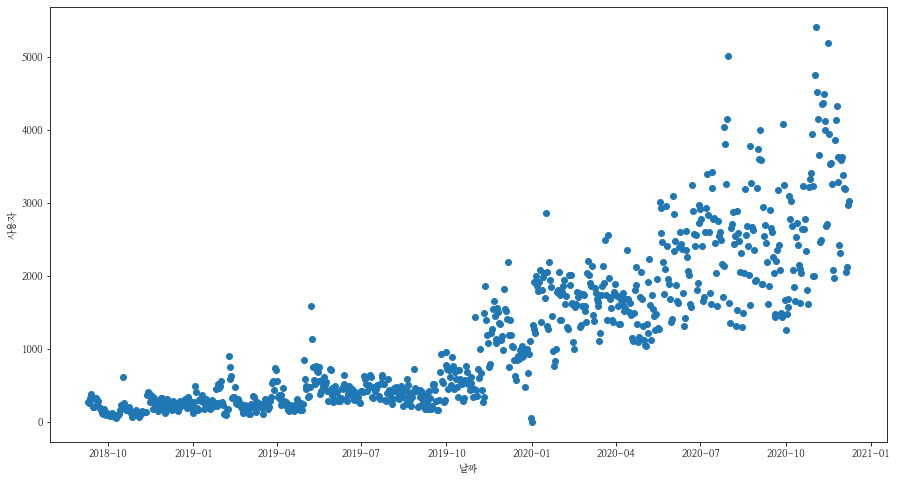

In [25]:
plt.figure(figsize = (15, 8))
plt.scatter(x = train['date'], y =train['사용자'])
plt.ylabel('사용자')
plt.xlabel('날짜')

### Feature Extraction 

In [34]:
comp = info_comp.dropna(how = 'all')
login = info_login.dropna(how = 'all')
user = info_user.dropna(how = 'all')
sub = info_sub.dropna(how ='all')

In [35]:
print(info_comp.shape, info_login.shape, info_user.shape, info_sub.shape)
print(comp.shape, login.shape, user.shape, sub.shape)

(52, 17) (164121, 6) (25011, 10) (113635, 6)
(51, 17) (161408, 6) (24606, 10) (110272, 6)


In [36]:
comp['period_start'] = pd.to_datetime(comp['period_start'])
comp['period_end'] = pd.to_datetime(comp['period_end'])
comp['start_date'] = comp['period_start'].dt.date
comp['end_date'] = comp['period_end'].dt.date

In [37]:
start_comp_fe = comp.groupby('start_date').count().reset_index()[['start_date', 'cpt_id']]

In [40]:
start_comp_fe.columns = ['date','start_comp_count']

In [41]:
end_comp_fe = comp.groupby('end_date').count().reset_index()[['end_date','cpt_id']]
end_comp_fe.columns = ['date','end_comp_count']

In [43]:
# login 데이터 일별로 summary 
login.head(3)

,Unnamed: 0,login_id,user_id,c_time,platform,browser
0,0.0,14196.0,14446.0,2018-09-23 1:30,Windows 8,Internet Explorer 10.0
1,1.0,14234.0,7287.0,2018-09-23 2:46,Windows,Chrome 67.0.3396.99
2,2.0,14256.0,7356.0,2018-09-23 3:35,Windows,Chrome 69.0.3497.100
